In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
from scipy import stats
from data_loader import preprocess_geo_data
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut, cross_val_predict, cross_val_score

In [2]:
file_path = "GSE24009_series_matrix.txt"

#Chamar a função para carregar e pré-processar os dados
df_expression_final, sample_titles = preprocess_geo_data(file_path)

In [16]:
print(df_expression_final.head())

ID_REF      1.1.1.1  1.1.1.10  1.1.1.11  1.1.1.12  1.1.1.13  1.1.1.14  \
Sample_ID                                                               
GSM591265  0.557653  0.137504  0.137504       NaN  0.137504  0.137504   
GSM591267  1.233391  0.367878  0.137504  0.137504  0.572399  0.137504   
GSM591269  0.428648       NaN  1.095927  0.137504       NaN  0.137504   
GSM591271  0.137504       NaN  0.137504       NaN  1.584963  0.783939   
GSM591273  0.558851  0.137504       NaN  0.303352  0.411995  0.137504   

ID_REF     1.1.1.15  1.1.1.16  1.1.1.17  1.1.1.18  ...  9.4.9.21  9.4.9.22  \
Sample_ID                                          ...                       
GSM591265       NaN       NaN       NaN  0.279088  ...  0.909827  2.315258   
GSM591267  0.137504       NaN       NaN       NaN  ...  1.638438  0.137504   
GSM591269  1.282712  0.945607       NaN  0.137504  ...  0.137504  0.137504   
GSM591271  1.225754  0.137504       NaN  0.137504  ...       NaN  0.137504   
GSM591273  0.137504 

In [15]:
# Transforma NaN em 0
df_sem_nan = df_expression_final.fillna(0)

print(f"\n Valores missing: {df_sem_nan.isna().sum().sum()}")
print(f" Valores zero: {(df_sem_nan.select_dtypes(include=np.number) == 0).sum().sum()}")

print(df_sem_nan.columns)


 Valores missing: 0
 Valores zero: 40163
Index(['1.1.1.1', '1.1.1.10', '1.1.1.11', '1.1.1.12', '1.1.1.13', '1.1.1.14',
       '1.1.1.15', '1.1.1.16', '1.1.1.17', '1.1.1.18',
       ...
       '9.4.9.21', '9.4.9.22', '9.4.9.3', '9.4.9.4', '9.4.9.5', '9.4.9.6',
       '9.4.9.7', '9.4.9.8', '9.4.9.9', 'Grupo'],
      dtype='object', name='ID_REF', length=23233)


In [4]:
# Separação dos grupos
grupo_pigmented = df_sem_nan[df_sem_nan['Grupo'] == 'pigmented']
grupo_non_pigmented = df_sem_nan[df_sem_nan['Grupo'] == 'non_pigmented']

print(grupo_pigmented.head())
print(grupo_non_pigmented.head())

ID_REF      1.1.1.1  1.1.1.10  1.1.1.11  1.1.1.12  1.1.1.13  1.1.1.14  \
Sample_ID                                                               
GSM591265  0.557653  0.137504  0.137504  0.000000  0.137504  0.137504   
GSM591269  0.428648  0.000000  1.095927  0.137504  0.000000  0.137504   
GSM591271  0.137504  0.000000  0.137504  0.000000  1.584963  0.783939   
GSM591275  0.228264  1.029631  0.137504  1.178259  0.000000  0.137504   
GSM591277  1.089238  0.973409  0.137504  0.137504  0.137504  0.137504   

ID_REF     1.1.1.15  1.1.1.16  1.1.1.17  1.1.1.18  ...  9.4.9.21  9.4.9.22  \
Sample_ID                                          ...                       
GSM591265  0.000000  0.000000  0.000000  0.279088  ...  0.909827  2.315258   
GSM591269  1.282712  0.945607  0.000000  0.137504  ...  0.137504  0.137504   
GSM591271  1.225754  0.137504  0.000000  0.137504  ...  0.000000  0.137504   
GSM591275  0.137504  0.825843  0.137504  0.137504  ...  0.000000  0.137504   
GSM591277  0.907748 

In [5]:
pigmented_vals = grupo_pigmented.drop(columns='Grupo')
non_pigmented_vals = grupo_non_pigmented.drop(columns='Grupo')
            
            
# AGORA fazer o teste t GENE POR GENE
resultados = []

for gene in pigmented_vals.columns:
    try:
        # Pegar valores específicos deste gene
        vals_pig = pigmented_vals[gene].dropna()
        vals_non_pig = non_pigmented_vals[gene].dropna()
        
        # Verificar se temos dados suficientes
        if len(vals_pig) < 2 or len(vals_non_pig) < 2:
            continue
            
        # Teste t para este gene específico
        t_stat, p_value = stats.ttest_ind(vals_non_pig, vals_pig, equal_var=False)
        
        # Calcular médias para este gene
        mean_pig = vals_pig.mean()
        mean_non_pig = vals_non_pig.mean()
        
        # Proteção contra divisão por zero (para este gene)
        if mean_pig == 0:
            mean_pig = 1e-10
            
        log2_fc = np.log2(mean_non_pig / mean_pig)
        
        resultados.append({
            'gene': gene,
            'p_value': p_value,
            't_statistic': t_stat,
            'log2_fold_change': log2_fc,
            'mean_pigmented': mean_pig,
            'mean_non_pigmented': mean_non_pig,
            'n_pigmented': len(vals_pig),
            'n_non_pigmented': len(vals_non_pig)
        })
        
    except Exception as e:
        print(f"Erro no gene {gene}: {e}")
        continue

C:\Users\Usuario\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_2952\2033842242.py:29: RuntimeWarning: divide by zero encountered in log2
  log2_fc = np.log2(mean_non_pig / mean_pig)


In [20]:
# Converter para DataFrame
df_resultados = pd.DataFrame(resultados)

if not df_resultados.empty:
    df_resultados = df_resultados.sort_values('p_value')
    print(f"\nAnálise completa! {len(df_resultados)} genes analisados")
    print("\nTop 10 genes mais significativos:")
    print(df_resultados.head(10))
else:
    print("Nenhum gene pôde ser analisado")


Análise completa! 23232 genes analisados

Top 10 genes mais significativos:
            gene   p_value  t_statistic  log2_fold_change  mean_pigmented  \
13406   4.4.3.17  0.000002    12.746728          3.464585        0.172857   
15954   6.1.9.13  0.000002     9.880745          2.745708        0.235194   
8259   2.2.10.18  0.000007     9.480215          3.226997        0.156361   
12826    4.3.2.1  0.000010     8.262539          2.430278        0.260712   
10516    3.2.4.1  0.000013     8.318678          2.333746        0.319235   
9353   2.4.16.12  0.000034     8.682793          1.801235        0.191714   
22829   9.4.12.3  0.000092     6.776136          1.814649        0.279337   
2770    10.2.3.8  0.000112     6.161268          1.884794        0.323549   
3239   10.3.3.14  0.000117     6.180912          1.776967        0.524427   
16497   6.3.10.7  0.000119     8.091796          2.945242        0.267940   

       mean_non_pigmented  n_pigmented  n_non_pigmented  
13406            

In [7]:
print('Genes significativos menores que 0.05 antes da correção: ',len(df_resultados[df_resultados['p_value'] < 0.05]))

Genes significativos menores que 0.05 antes da correção:  1277


In [28]:
# Aplicar correção FDR
rejected, p_adjusted, _, _ = multipletests(df_resultados['p_value'], alpha=0.05, method='fdr_bh')

df_resultados['p_adj'] = p_adjusted
df_resultados['significant_fdr'] = rejected

print(f" Genes significativos após FDR: {df_resultados['significant_fdr'].sum()}")
print(df_resultados[df_resultados['significant_fdr']])
fdr_genes = df_resultados[df_resultados['significant_fdr']]

 Genes significativos após FDR: 2
           gene   p_value  t_statistic  log2_fold_change  mean_pigmented  \
13406  4.4.3.17  0.000002    12.746728          3.464585        0.172857   
15954  6.1.9.13  0.000002     9.880745          2.745708        0.235194   

       mean_non_pigmented  n_pigmented  n_non_pigmented  neg_log10_pvalue  \
13406            1.908232            8                4          5.730272   
15954            1.577492            8                4          5.720999   

       significant  p_adj  significant_fdr  
13406         True    NaN             True  
15954         True    NaN             True  


In [29]:
print(df_resultados.columns)

Index(['gene', 'p_value', 't_statistic', 'log2_fold_change', 'mean_pigmented',
       'mean_non_pigmented', 'n_pigmented', 'n_non_pigmented',
       'neg_log10_pvalue', 'significant', 'p_adj', 'significant_fdr'],
      dtype='object')


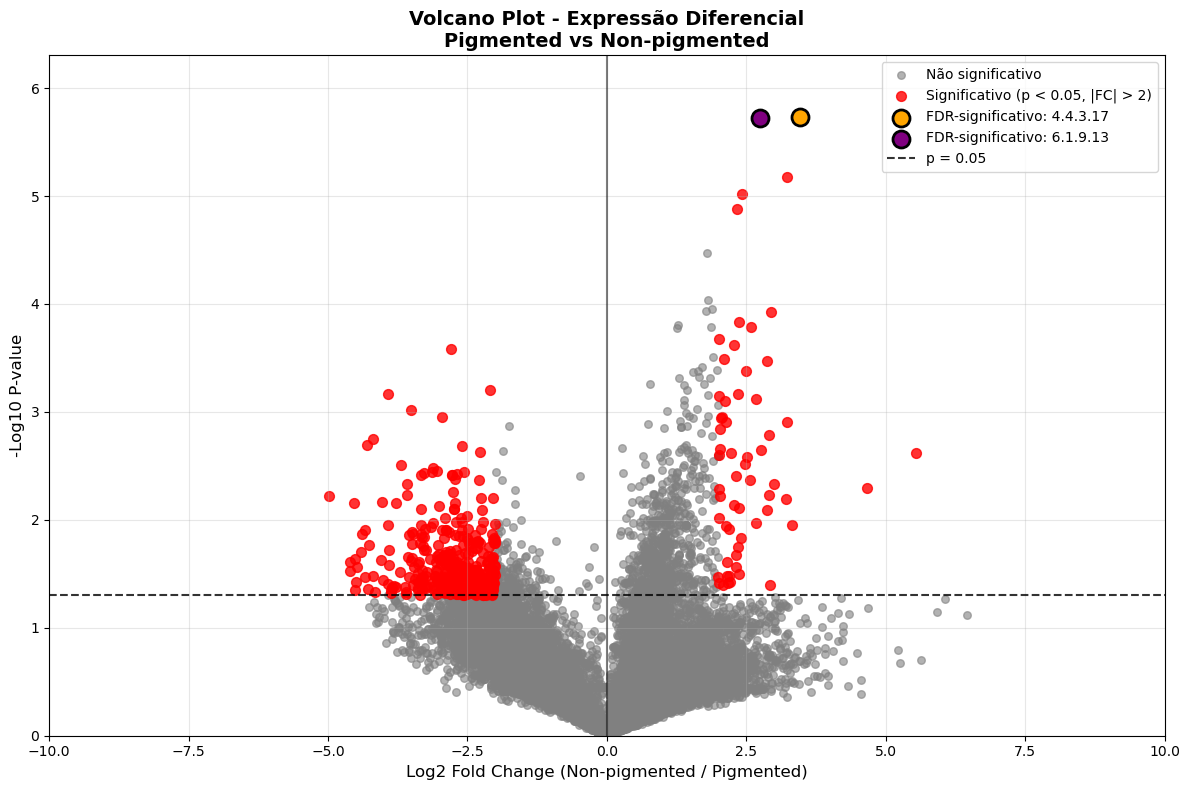

In [30]:
# Volcano Plot
plt.style.use('default')
sns.set_palette("viridis")

# Criar coluna para -log10(p-value) no DataFrame principal
df_resultados['neg_log10_pvalue'] = -np.log10(df_resultados['p_value'])

# Identificar pontos significativos (exemplo: p < 0.05 e |FC| > 1)
df_resultados['significant'] = (df_resultados['p_value'] < 0.05) & (df_resultados['log2_fold_change'].abs() > 2)

# Criar figura
plt.figure(figsize=(12, 8))

# Plotar pontos não significativos
ns_data = df_resultados[~df_resultados['significant']]
plt.scatter(ns_data['log2_fold_change'], ns_data['neg_log10_pvalue'],
           alpha=0.6, s=30, color='gray', label='Não significativo')

# Plotar pontos significativos
sig_data = df_resultados[df_resultados['significant']]
plt.scatter(sig_data['log2_fold_change'], sig_data['neg_log10_pvalue'],
           alpha=0.8, s=50, color='red', label='Significativo (p < 0.05, |FC| > 2)')

# 3. Plotar os 2 genes FDR-significativos com CORES DIFERENTES
if len(fdr_genes) > 0:
    # Primeiro, calcular a coluna neg_log10_pvalue também para fdr_genes
    fdr_genes = fdr_genes.copy()  # Criar uma cópia para evitar warnings
    fdr_genes['neg_log10_pvalue'] = -np.log10(fdr_genes['p_value'])
    
    # Primeiro gene FDR - COR LARANJA
    gene1 = fdr_genes.iloc[0]
    plt.scatter(gene1['log2_fold_change'], gene1['neg_log10_pvalue'],
               alpha=1.0, s=150, color='orange', edgecolor='black', linewidth=2,
               label=f'FDR-significativo: {gene1["gene"]}')
    
    # Segundo gene FDR - COR ROXO
    if len(fdr_genes) > 1:
        gene2 = fdr_genes.iloc[1]
        plt.scatter(gene2['log2_fold_change'], gene2['neg_log10_pvalue'],
                   alpha=1.0, s=150, color='purple', edgecolor='black', linewidth=2,
                   label=f'FDR-significativo: {gene2["gene"]}')

# Linhas de referência
plt.axhline(-np.log10(0.05), color='black', linestyle='--', alpha=0.8, label='p = 0.05')
plt.axvline(0, color='black', linestyle='-', alpha=0.5)

# Labels e título
plt.xlabel('Log2 Fold Change (Non-pigmented / Pigmented)', fontsize=12)
plt.ylabel('-Log10 P-value', fontsize=12)
plt.title('Volcano Plot - Expressão Diferencial\nPigmented vs Non-pigmented', fontsize=14, fontweight='bold')

# Legenda
plt.legend()

# Grid
plt.grid(True, alpha=0.3)

# Ajustar limites se necessário
plt.xlim(-10, 10)  # Ajuste conforme seus dados
plt.ylim(0, df_resultados['neg_log10_pvalue'].max() * 1.1)

plt.tight_layout()
plt.show()

In [31]:
# Estatísticas do plot
print(f"Estatísticas do Volcano Plot:")
print(f"Total de pontos: {len(df_resultados)}")
print(f"Pontos significativos: {df_resultados['significant'].sum()}")
print(f"Maior -log10(p-value): {df_resultados['neg_log10_pvalue'].max():.1f}")
print(f"Range do Fold Change: [{df_resultados['log2_fold_change'].min():.1f}, {df_resultados['log2_fold_change'].max():.1f}]")

Estatísticas do Volcano Plot:
Total de pontos: 23232
Pontos significativos: 426
Maior -log10(p-value): 5.7
Range do Fold Change: [-inf, 32.2]


In [32]:
df_resultados.columns

Index(['gene', 'p_value', 't_statistic', 'log2_fold_change', 'mean_pigmented',
       'mean_non_pigmented', 'n_pigmented', 'n_non_pigmented',
       'neg_log10_pvalue', 'significant', 'p_adj', 'significant_fdr'],
      dtype='object')

In [33]:
# Selecionar apenas as colunas desejadas
analise = df_resultados[['gene', 'p_value', 'log2_fold_change', 'significant', 'significant_fdr']]

# Genes significativos p < 0.05, |FC| > 2
analise_significativos = analise[analise['significant'] == True]
analise_significativos = analise_significativos.sort_values('p_value')
print(f"\nGenes significativos: {len(analise_significativos)}")
print('O log2_fold_change quando é negativo ele é sobre o grupo pigmentado')
print(analise_significativos.head(20))


Genes significativos: 426
O log2_fold_change quando é negativo ele é sobre o grupo pigmentado
             gene   p_value  log2_fold_change  significant  significant_fdr
13406    4.4.3.17  0.000002          3.464585         True             True
15954    6.1.9.13  0.000002          2.745708         True             True
8259    2.2.10.18  0.000007          3.226997         True            False
12826     4.3.2.1  0.000010          2.430278         True            False
10516     3.2.4.1  0.000013          2.333746         True            False
16497    6.3.10.7  0.000119          2.945242         True            False
9794    3.1.14.13  0.000148          2.368070         True            False
3223    10.3.22.2  0.000165          2.578150         True            False
6349   12.2.11.21  0.000212          2.015599         True            False
11012    3.3.4.20  0.000238          2.276702         True            False
1589    1.4.15.14  0.000262         -2.800970         True           

In [34]:
#Seleção de genes para o modelo

fdr_genes = df_resultados[df_resultados['significant_fdr']]['gene'].tolist()

# Pegar top genes por magnitude do fold change (valor absoluto)
df_resultados['abs_fc'] = abs(df_resultados['log2_fold_change'])  # Valor absoluto
top_genes_df = df_resultados.nlargest(2, 'abs_fc')  #  genes com maior |log2FC|
top_genes = top_genes_df['gene'].tolist()  # Extrair lista de genes

# Combinar e remover duplicatas
selected_genes = list(set(fdr_genes + top_genes))

print(f"Genes FDR: {fdr_genes}")
print(f"Top genes por |FC|: {top_genes}")
print(f"Genes selecionados: {selected_genes}")

Genes FDR: ['4.4.3.17', '6.1.9.13']
Top genes por |FC|: ['5.3.15.15', '12.2.20.2']
Genes selecionados: ['6.1.9.13', '5.3.15.15', '12.2.20.2', '4.4.3.17']


In [35]:
# Criar matriz de features (X) e target (y)
X = df_sem_nan[selected_genes].copy()  # Genes como features
y = df_sem_nan['Grupo'].map({'pigmented': 0, 'non_pigmented': 1})  # Converter para 0/1

print(f"Dimensões: X={X.shape}, y={y.shape}")

Dimensões: X=(12, 4), y=(12,)


In [60]:
print(y)

Sample_ID
GSM591265    0
GSM591267    1
GSM591269    0
GSM591271    0
GSM591273    1
GSM591275    0
GSM591277    0
GSM591279    1
GSM591281    0
GSM591283    0
GSM591287    1
GSM591289    0
Name: Grupo, dtype: int64


In [36]:
# Pipeline com scaling e modelo
model = Pipeline([
    ('scaler', StandardScaler()),  
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, penalty='l2', C=0.1))])

# Treinar o modelo
model.fit(X, y)

print("Modelo treinado!")

Modelo treinado!


In [37]:
# LOOCV
loo = LeaveOneOut()
cv_scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')

print(f"Acurácia média: {cv_scores.mean():.3f}")
print(f" Acurácia por amostra: {cv_scores}")

Acurácia média: 1.000
 Acurácia por amostra: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


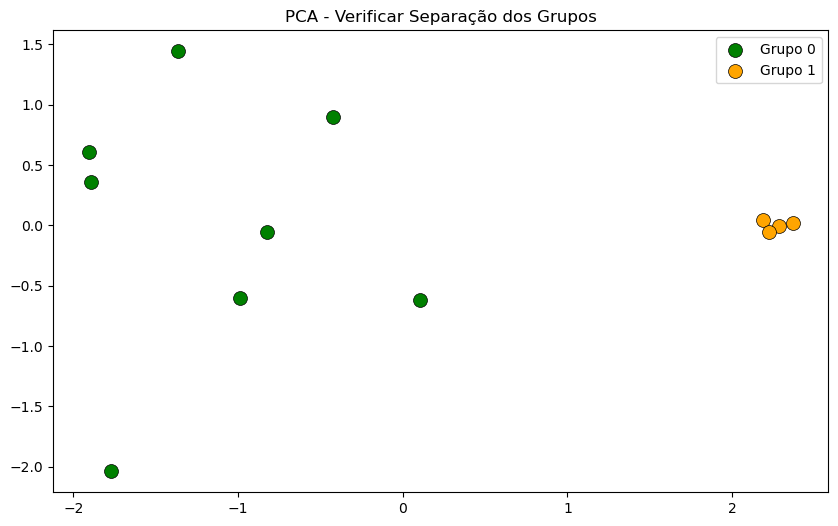

In [75]:
plt.figure(figsize=(10, 6))
color_map = {0: 'green', 1: 'orange'}  # Mapeamento personalizado

for label in [0, 1]:
    mask = y == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=color_map[label],     # Busca a cor no dicionário
                label=f'Grupo {label}', 
                s=100, 
                edgecolor='black',      # Borda preta (opcional)
                linewidth=0.5)          # Espessura da borda

plt.title('PCA - Verificar Separação dos Grupos')
plt.legend()
plt.show()
#Grupo 0 pigmentado
#grupo 1 nao pigmentado

In [38]:
#Verificação robusta dos resultados
def verificar_resultado(X, y, model):
    print("VERIFICAÇÃO DE RESULTADO 100%")
    print("=" * 50)
    
    # 1. LOOCV tradicional
    loo_scores = cross_val_score(model, X, y, cv=LeaveOneOut())
    print(f"LOOCV: {loo_scores.mean():.3f}")
    
    # 2. Validação mais conservadora
    rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=20, random_state=42)
    robust_scores = cross_val_score(model, X, y, cv=rskf)
    print(f"Repeated K-Fold: {robust_scores.mean():.3f} (±{robust_scores.std():.3f})")
    
    
    return robust_scores.mean()

# Executar verificação
acc_real = verificar_resultado(X, y, model)

VERIFICAÇÃO DE RESULTADO 100%
LOOCV: 1.000
Repeated K-Fold: 0.833 (±0.236)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_26976\2519533455.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_group0, data_group1],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26976\2519533455.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_group0, data_group1],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26976\2519533455.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_group0, data_group1],
C:\Users\Usuario\AppData\Local\Temp\ipykernel_26976\2519533455.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tic

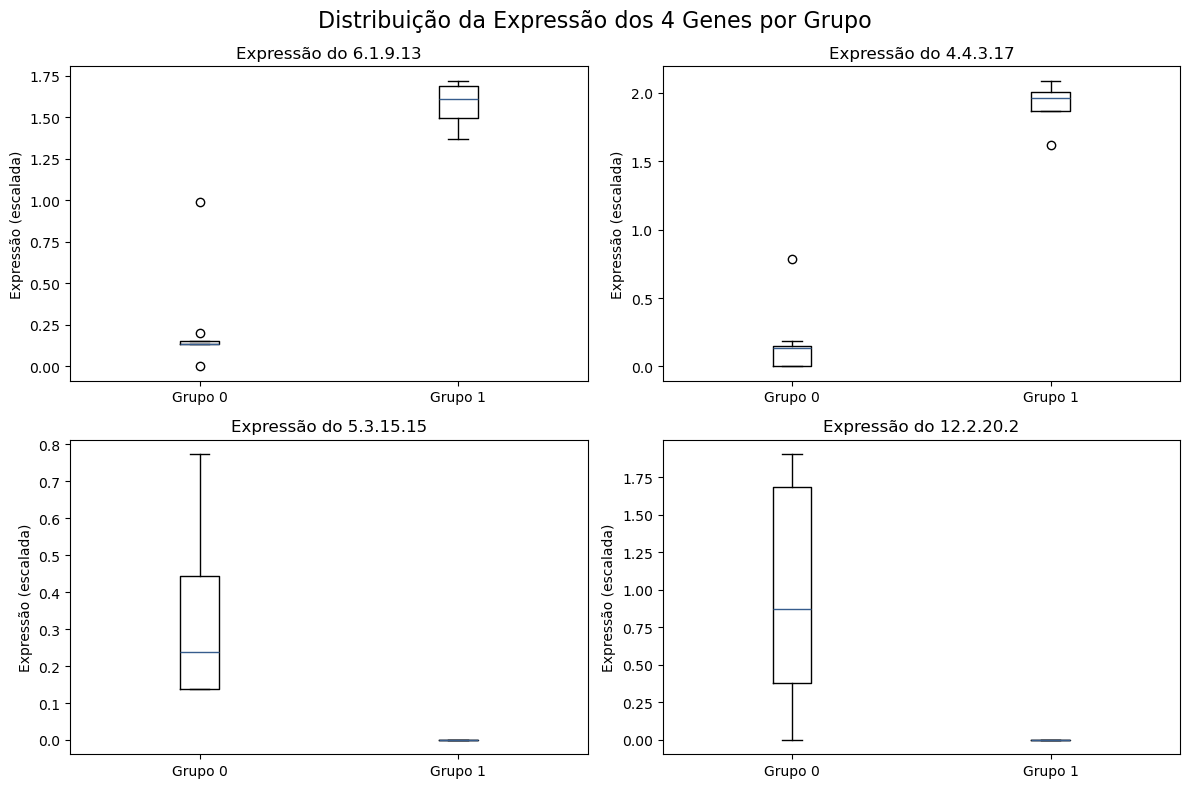

In [70]:
#Bloxplot
# Supondo que X seja seu dataframe com os 4 genes e y as labels
plt.figure(figsize=(12, 8))
for i, gene in enumerate(X.columns, 1):
    plt.subplot(2, 2, i)
    
    # Dados para cada grupo
    data_group0 = X[y == 0][gene]
    data_group1 = X[y == 1][gene]
    
    plt.boxplot([data_group0, data_group1], 
                labels=['Grupo 0', 'Grupo 1'])
    plt.title(f'Expressão do {gene}')
    plt.ylabel('Expressão (escalada)')

plt.suptitle('Distribuição da Expressão dos 4 Genes por Grupo', fontsize=16)
plt.tight_layout()
plt.show()

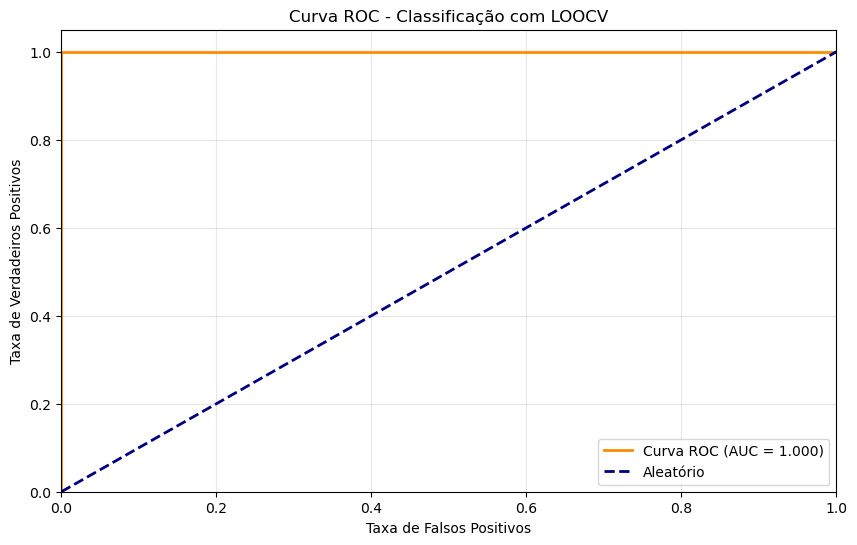

AUC: 1.000


In [77]:
# LOOCV para obter probabilidades
loo = LeaveOneOut()
model = LogisticRegression()
probas = []
y_true = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    probas.append(model.predict_proba(X_test)[0, 1])
    y_true.append(y_test.iloc[0])

probas = np.array(probas)
y_true = np.array(y_true)

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_true, probas)
roc_auc = auc(fpr, tpr)

# Plotar curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Classificação com LOOCV')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC: {roc_auc:.3f}")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_26976\2425086869.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([probas_group0, probas_group1],


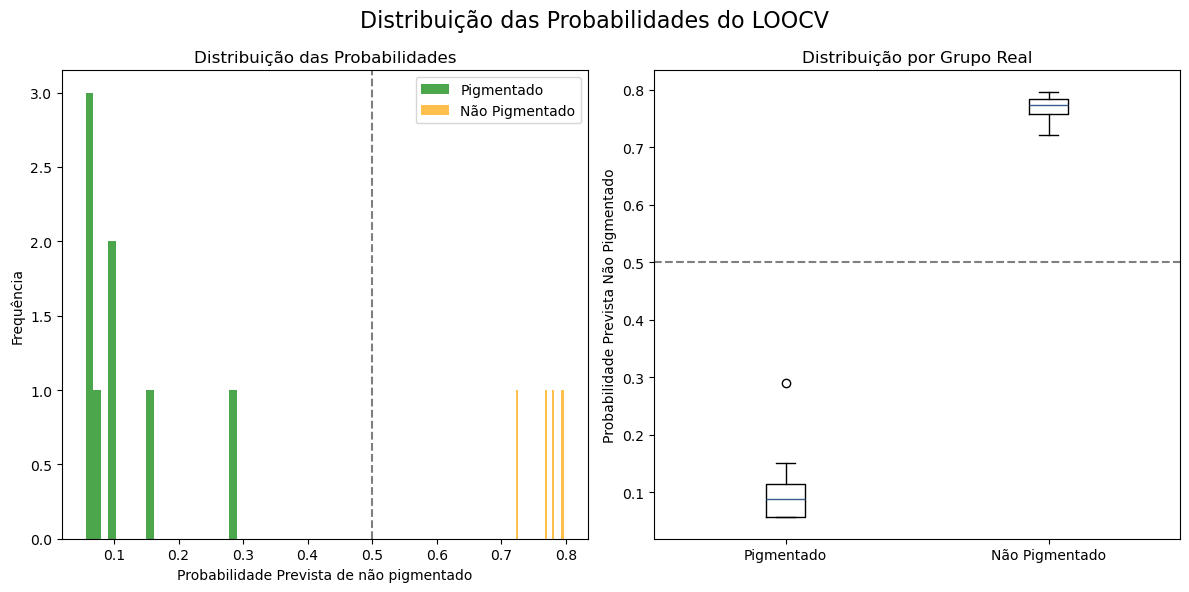

Estatísticas das probabilidades:
Grupo 0 - Média: 0.112, Std: 0.074
Grupo 1 - Média: 0.767, Std: 0.028


In [84]:
plt.figure(figsize=(12, 6))

# Separar probabilidades por classe real
probas_group0 = probas[y_true == 0]
probas_group1 = probas[y_true == 1]

# Histograma
plt.subplot(1, 2, 1)
plt.hist(probas_group0, alpha=0.7, bins=20, label='Pigmentado', color='green')
plt.hist(probas_group1, alpha=0.7, bins=20, label='Não Pigmentado', color='orange')
plt.xlabel('Probabilidade Prevista de não pigmentado')
plt.ylabel('Frequência')
plt.title('Distribuição das Probabilidades')
plt.legend()
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)

# Boxplot das probabilidades
plt.subplot(1, 2, 2)
plt.boxplot([probas_group0, probas_group1], 
            labels=['Pigmentado', 'Não Pigmentado'])
plt.ylabel('Probabilidade Prevista Não Pigmentado')
plt.title('Distribuição por Grupo Real')
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)

plt.suptitle('Distribuição das Probabilidades do LOOCV', fontsize=16)
plt.tight_layout()
plt.show()

# Estatísticas descritivas
print("Estatísticas das probabilidades:")
print(f"Grupo 0 - Média: {probas_group0.mean():.3f}, Std: {probas_group0.std():.3f}")
print(f"Grupo 1 - Média: {probas_group1.mean():.3f}, Std: {probas_group1.std():.3f}")

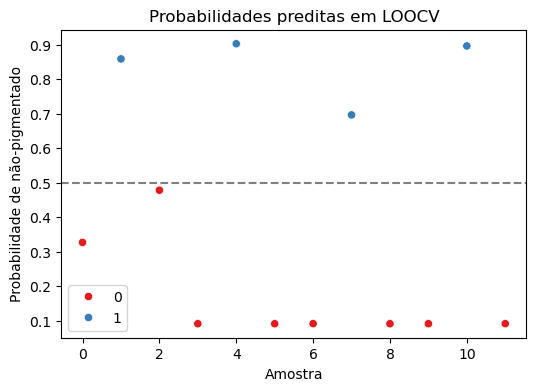

In [49]:
#Distribuição das probabilidades (LOOCV)

X = genes_analise.drop(columns=['Grupo']).values
y = genes_analise['Grupo'].map({'pigmented': 0, 'non_pigmented': 1}).values

outer = LeaveOneOut()
probas = []
true_labels = []

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(penalty='elasticnet', solver='saga',
                               l1_ratio=0.5, max_iter=5000,
                               class_weight='balanced'))
])

for train_idx, test_idx in outer.split(X, y):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_te)[:,1][0]
    probas.append(proba)
    true_labels.append(y_te[0])

# Plotar
plt.figure(figsize=(6,4))
sns.scatterplot(x=range(len(probas)), y=probas, hue=true_labels, palette='Set1')
plt.axhline(0.5, color='gray', linestyle='--')
plt.title("Probabilidades preditas em LOOCV")
plt.xlabel("Amostra")
plt.ylabel("Probabilidade de não-pigmentado")
plt.show()